# classification : 分類問題

# Preparation

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220301/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 7.8 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

## データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


## ニューラルネットワークの定義

In [8]:
class Model(torch.nn.Module):

  class Net( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        return x

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      loss = nn.CrossEntropyLoss()
      #loss = nn.NLLLoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( Model, self ).__init__()
    print("create model class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    out = self.loss( self.out, self.target )
    return out

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'clas'
folder = './classification'
json_path = folder + '/' + project +'.json'

In [10]:
! mkdir -p classification

## 計算グラフをJSONファイルに出力する

In [11]:
def generate_json( json_path, input, target ):
    model = Model( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [12]:
torch.manual_seed( 1 )

batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]
inputs.requires_grad = True

model = generate_json( json_path, inputs, labels )

torch.Size([112, 4])
torch.Size([112])
create model class
create loss class
[SAVE] ./classification/clas.json
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc2]/weight/fc2
skip: Model/Net[net]/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, inputs, {"input_data":x_train, "target_data":y_train}, sol="classification", batch=batch_size, shuffle=1 )

[JSON] ./classification/clas.json
param: xin  - str loop  7  /  7
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
param: fc1_weight  - str loop  31  /  31
{'name': 'Model/Net[net]/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
param: fc1_bias  - str loop  7  /  7
{'name': 'Model/Net[net]/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
param: fc2_weight  - str loop  23  /  23
{'name': 'Model/Net[net]/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
param: fc2_bias  - str loop  0  /  0
{'name': 'Model/Loss[loss]/60', 'op': 'prim::Constant', 'in': [], 'output_id': 0, 'shape': [16], 'constant_value': [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0], 'out': [13], 

In [14]:
#check code
with torch.set_grad_enabled(True):
  output = model( inputs )
  print("output",output)

  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.2230, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[ 5.8476e-03,  6.7604e-03, -7.2637e-03,  6.0405e-03],
        [-7.9384e-03, -3.0973e-03,  2.6394e-03, -3.3715e-03],
        [-1.0245e-02,  2.2382e-03,  2.5780e-03,  2.4660e-03],
        [-1.0441e-02, -4.4734e-03,  8.1803e-04, -1.2004e-03],
        [-8.7963e-03, -3.3808e-03,  3.0529e-03, -3.1631e-03],
        [-1.0380e-02, -4.0114e-03,  6.0313e-04, -7.5406e-04],
        [-1.0110e-02, -3.2949e-04,  1.0401e-03, -1.4164e-03],
        [-9.4295e-03, -4.2660e-03,  2.4077e-03, -2.1478e-03],
        [-3.2351e-03, -9.3771e-04, -3.2520e-03, -9.3773e-03],
        [ 2.2504e-03,  7.6834e-03, -2.8690e-04,  4.4780e-03],
        [-9.3166e-03, -4.2519e-03,  2.4009e-03, -2.1151e-03],
        [ 6.3980e-03,  3.4069e-03, -2.8923e-04,  2.6745e-03],
        [ 9.5126e-05, -4.1789e-03, -7.5628e-04, -1.0744e-02],
        [ 6.8320e-03,  5.5266e-03, -4.1355e-03,  4.5189e-03],
        [-9.1594e-03, -3.8562e-03,  2.1921e-03, -1.719

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

# コンパイル

In [16]:
C_SRC = './classification/clas.cpp ./classification/clas_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './classification/clas'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas.cpp ./classification/clas_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas


In [17]:
!./classification/clas

### forward computation ...
 1.222979
### backward computation ...
input_grad{{ 0.005848,  0.00676 , -0.007264,  0.00604 },
 {-0.007938, -0.003097,  0.002639, -0.003371},
 {-0.010245,  0.002238,  0.002578,  0.002466},
 {-0.010441, -0.004473,  0.000818, -0.0012  },
 {-0.008796, -0.003381,  0.003053, -0.003163},
 {-0.01038 , -0.004011,  0.000603, -0.000754},
 {-0.01011 , -0.000329,  0.00104 , -0.001416},
 {-0.00943 , -0.004266,  0.002408, -0.002148},
 {-0.003235, -0.000938, -0.003252, -0.009377},
 { 0.00225 ,  0.007683, -0.000287,  0.004478},
 {-0.009317, -0.004252,  0.002401, -0.002115},
 { 0.006398,  0.003407, -0.000289,  0.002675},
 { 0.000095, -0.004179, -0.000756, -0.010744},
 { 0.006832,  0.005527, -0.004135,  0.004519},
 {-0.009159, -0.003856,  0.002192, -0.001719},
 {-0.00357 , -0.000872, -0.004247, -0.007272}}


# Python 学習コード

In [20]:
torch.manual_seed( 1 )

#inputs.requires_grad = True
model = Model( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += float(loss);

        # 正解数の合計を更新
        #_, preds = torch.max( model.out, 1 )
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

create model class
create loss class
batch 7 112 16
Train Loss 0: 7.6943 Acc: 0.1607 18
Train Loss 1: 6.6936 Acc: 0.4464 50
Train Loss 2: 5.9656 Acc: 0.6696 75
Train Loss 3: 5.4120 Acc: 0.6786 76
Train Loss 4: 4.9974 Acc: 0.7054 79
Train Loss 5: 4.6748 Acc: 0.7054 79
Train Loss 6: 4.4159 Acc: 0.7232 81
Train Loss 7: 4.2083 Acc: 0.7321 82
Train Loss 8: 4.0257 Acc: 0.7321 82
Train Loss 9: 3.8686 Acc: 0.7679 86
Train Loss 10: 3.7324 Acc: 0.7946 89
Train Loss 11: 3.6174 Acc: 0.8036 90
Train Loss 12: 3.5072 Acc: 0.8125 91
Train Loss 13: 3.4100 Acc: 0.8304 93
Train Loss 14: 3.3225 Acc: 0.8304 93
Train Loss 15: 3.2395 Acc: 0.8482 95
Train Loss 16: 3.1634 Acc: 0.8482 95
Train Loss 17: 3.0932 Acc: 0.8571 96
Train Loss 18: 3.0285 Acc: 0.8571 96
Train Loss 19: 2.9714 Acc: 0.8571 96
Train Loss 20: 2.9131 Acc: 0.8571 96
Train Loss 21: 2.8585 Acc: 0.8661 97
Train Loss 22: 2.8125 Acc: 0.8750 98
Train Loss 23: 2.7615 Acc: 0.8750 98
Train Loss 24: 2.7173 Acc: 0.8750 98
Train Loss 25: 2.6720 Acc: 0.8839

収束状況グラフを描画する

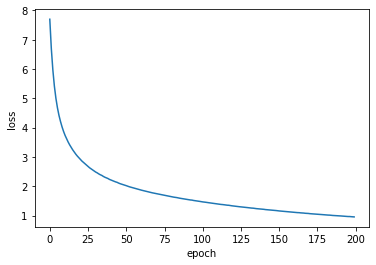

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

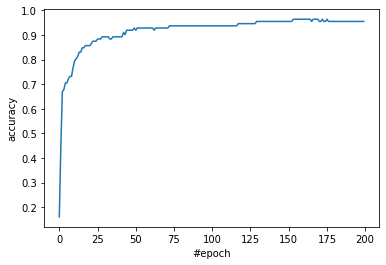

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

# C++ 学習コード

学習用C++コードをコンパイル、リンクする

In [23]:
C_SRC = './classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './classification/clas_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas_train


In [24]:
! ./classification/clas_train

epoch_num : 200
batch  number  : 7,16
learning ratio : 0.01
total_loss (batch): epoch 0 : loss 7.69356 : Acc 0.169643 19
total_loss (all)  : epoch 0 : loss 1.00887 : Acc 0.214286 24
total_loss (batch): epoch 1 : loss 6.69251 : Acc 0.383929 43
total_loss (all)  : epoch 1 : loss 0.889454 : Acc 0.651786 73
total_loss (batch): epoch 2 : loss 5.95441 : Acc 0.669643 75
total_loss (all)  : epoch 2 : loss 0.80157 : Acc 0.6875 77
total_loss (batch): epoch 3 : loss 5.41455 : Acc 0.705357 79
total_loss (all)  : epoch 3 : loss 0.73524 : Acc 0.705357 79
total_loss (batch): epoch 4 : loss 4.99579 : Acc 0.705357 79
total_loss (all)  : epoch 4 : loss 0.684408 : Acc 0.705357 79
total_loss (batch): epoch 5 : loss 4.67299 : Acc 0.714286 80
total_loss (all)  : epoch 5 : loss 0.644254 : Acc 0.723214 81
total_loss (batch): epoch 6 : loss 4.42133 : Acc 0.723214 81
total_loss (all)  : epoch 6 : loss 0.611452 : Acc 0.732143 82
total_loss (batch): epoch 7 : loss 4.19809 : Acc 0.741071 83
total_loss (all)  : epo

In [25]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("[OUT]",path)
print("epoch =", len(loss))
print( loss )
print(acc)

[OUT] ./classification/clas.out
epoch = 200
[1.008875, 0.889454, 0.80157, 0.73524, 0.684408, 0.644254, 0.611452, 0.584133, 0.560727, 0.540494, 0.522588, 0.506653, 0.492255, 0.479129, 0.467097, 0.456023, 0.445766, 0.436211, 0.427297, 0.418936, 0.411078, 0.403676, 0.396676, 0.390058, 0.383776, 0.377812, 0.372132, 0.366717, 0.361556, 0.356618, 0.351885, 0.347358, 0.343016, 0.338839, 0.334826, 0.330963, 0.327245, 0.323657, 0.320199, 0.316852, 0.31362, 0.310489, 0.307464, 0.304535, 0.301688, 0.29892, 0.296232, 0.29362, 0.291078, 0.288603, 0.286197, 0.283847, 0.281555, 0.279318, 0.277126, 0.274983, 0.272892, 0.270843, 0.268833, 0.266866, 0.264935, 0.263045, 0.261192, 0.259373, 0.257591, 0.255849, 0.254136, 0.252455, 0.250801, 0.249174, 0.247572, 0.245998, 0.244446, 0.242917, 0.241408, 0.239922, 0.238458, 0.237016, 0.235595, 0.234193, 0.232813, 0.231449, 0.230103, 0.228776, 0.227462, 0.226166, 0.224881, 0.223617, 0.222367, 0.221135, 0.219915, 0.21871, 0.217521, 0.216342, 0.215176, 0.214023, 0

収束状況グラフを描画する

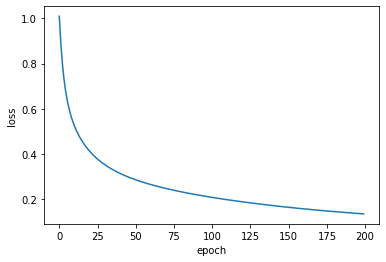

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

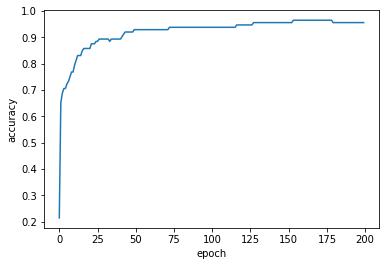

In [27]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()